 An Overview of Multimodal Use Cases


### Objectives

This notebook demonstrates a variety of multimodal use cases that Gemini can be used for.

#### Multimodal use cases

Compared to text-only LLMs, Gemini 1.0 Pro Vision's multimodality can be used for many new use-cases:

Example use cases with **text and image(s)** as input:

- Detecting objects in photos
- Understanding screens and interfaces
- Understanding of drawing and abstraction
- Understanding charts and diagrams
- Recommendation of images based on user preferences
- Comparing images for similarities, anomalies, or differences

Example use cases with **text and video** as input:

- Generating a video description
- Extracting tags of objects throughout a video
- Extracting highlights/messaging of a video


### Costs

This tutorial uses billable components of Google Cloud:

- Vertex AI

Learn about [Vertex AI pricing](https://cloud.google.com/vertex-ai/pricing) and use the [Pricing Calculator](https://cloud.google.com/products/calculator/) to generate a cost estimate based on your projected usage.


## Getting Started


### Install Vertex AI SDK for Python


In [56]:
! pip3 install --upgrade --user google-cloud-aiplatform

### Restart current runtime

To use the newly installed packages in this Jupyter runtime, you must restart the runtime. You can do this by running the cell below, which will restart the current kernel.

In [57]:
# Restart kernel after installs so that your environment can access the new packages
import IPython
import time

app = IPython.Application.instance()
app.kernel.do_shutdown(True)

{'status': 'ok', 'restart': True}

<div class="alert alert-block alert-warning">
<b>⚠️ The kernel is going to restart. Please wait until it is finished before continuing to the next step. ⚠️</b>
</div>



### Authenticate your notebook environment (Colab only)

If you are running this notebook on Google Colab, run the following cell to authenticate your environment. This step is not required if you are using [Vertex AI Workbench](https://cloud.google.com/vertex-ai-workbench).


In [1]:
import sys

# Additional authentication is required for Google Colab
if "google.colab" in sys.modules:
    # Authenticate user to Google Cloud
    from google.colab import auth

    auth.authenticate_user()

### Define Google Cloud project information and initialize Vertex AI

Initialize the Vertex AI SDK for Python for your project:

In [2]:
# Define project information
PROJECT_ID = "assignment-434502"  # @param {type:"string"}
LOCATION = "us-central1"  # @param {type:"string"}

# Initialize Vertex AI
import vertexai

vertexai.init(project=PROJECT_ID, location=LOCATION)

### Import libraries


In [3]:
from vertexai.generative_models import (
    GenerationConfig,
    GenerativeModel,
    Image,
    Part,
)

## Use the Gemini 1.0 Pro Vision model

Gemini 1.0 Pro Vision (`gemini-1.0-pro-vision`) is a multimodal model that supports multimodal prompts. You can include text, image(s), and video in your prompt requests and get text or code responses.


### Load Gemini 1.0 Pro Vision model


In [4]:
multimodal_model = GenerativeModel("gemini-1.0-pro-vision")

### Define helper functions


In [5]:
import http.client
import typing
import urllib.request

import IPython.display
from PIL import Image as PIL_Image
from PIL import ImageOps as PIL_ImageOps


def display_images(
    images: typing.Iterable[Image],
    max_width: int = 600,
    max_height: int = 350,
) -> None:
    for image in images:
        pil_image = typing.cast(PIL_Image.Image, image._pil_image)
        if pil_image.mode != "RGB":
            # RGB is supported by all Jupyter environments (e.g. RGBA is not yet)
            pil_image = pil_image.convert("RGB")
        image_width, image_height = pil_image.size
        if max_width < image_width or max_height < image_height:
            # Resize to display a smaller notebook image
            pil_image = PIL_ImageOps.contain(pil_image, (max_width, max_height))
        IPython.display.display(pil_image)


def get_image_bytes_from_url(image_url: str) -> bytes:
    with urllib.request.urlopen(image_url) as response:
        response = typing.cast(http.client.HTTPResponse, response)
        image_bytes = response.read()
    return image_bytes


def load_image_from_url(image_url: str) -> Image:
    image_bytes = get_image_bytes_from_url(image_url)
    return Image.from_bytes(image_bytes)


def display_content_as_image(content: str | Image | Part) -> bool:
    if not isinstance(content, Image):
        return False
    display_images([content])
    return True


def display_content_as_video(content: str | Image | Part) -> bool:
    if not isinstance(content, Part):
        return False
    part = typing.cast(Part, content)
    file_path = part.file_data.file_uri.removeprefix("gs://")
    video_url = f"https://storage.googleapis.com/{file_path}"
    IPython.display.display(IPython.display.Video(video_url, width=600))
    return True


def print_multimodal_prompt(contents: list[str | Image | Part]):
    """
    Given contents that would be sent to Gemini,
    output the full multimodal prompt for ease of readability.
    """
    for content in contents:
        if display_content_as_image(content):
            continue
        if display_content_as_video(content):
            continue
        print(content)

## Image understanding across multiple images

One of the capabilities of Gemini is being able to reason across multiple images.

This is an example of using Gemini to calculate the total cost of groceries using an image of fruits and a price list:


-------Prompt--------
Instructions: Consider the following image that contains fruits:


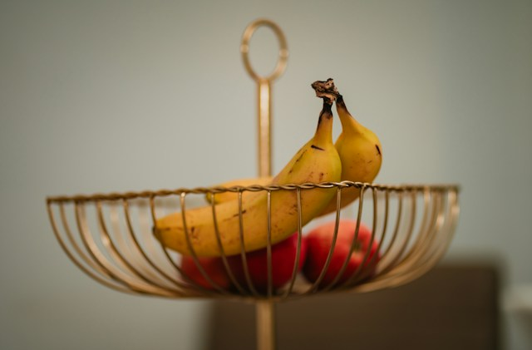

How much should I pay for the fruits given the following price list?


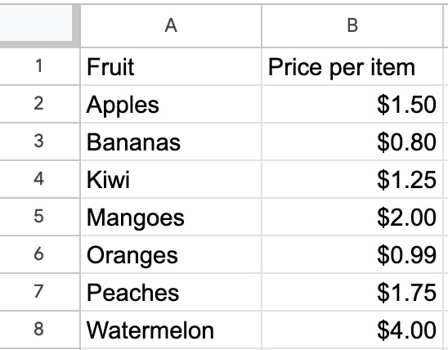


Answer the question through these steps:
Step 1: Identify what kind of fruits there are in the first image.
Step 2: Count the quantity of each fruit.
Step 3: For each grocery in first image, check the price of the grocery in the price list.
Step 4: Calculate the subtotal price for each type of fruit.
Step 5: Calculate the total price of fruits using the subtotals.

Answer and describe the steps taken:


-------Response--------
 **Step 1: Identify what kind of fruits there are in the first image.**
There are 2 bananas and 3 apples.

**Step 2: Count the quantity of each fruit.**
The quantity of bananas is 2.
The quantity of apples is 3.

**Step 3: For each grocery in first image, check the price of the grocery in the price list.**
The price of a banana is $0.80.
The price of an apple is $1.50.

**Step 4: Calculate the subtotal price for each type of fruit.**
The subtotal price for bananas is 2 * $0.80 = $1.60.
The subtotal price for apples is 3 * $1.50 = $4.50.

**Step 5: Calculate the 

In [6]:
image_grocery_url = "https://storage.googleapis.com/github-repo/img/gemini/multimodality_usecases_overview/banana-apple.jpg"
image_prices_url = "https://storage.googleapis.com/github-repo/img/gemini/multimodality_usecases_overview/pricelist.jpg"
image_grocery = load_image_from_url(image_grocery_url)
image_prices = load_image_from_url(image_prices_url)

instructions = "Instructions: Consider the following image that contains fruits:"
prompt1 = "How much should I pay for the fruits given the following price list?"
prompt2 = """
Answer the question through these steps:
Step 1: Identify what kind of fruits there are in the first image.
Step 2: Count the quantity of each fruit.
Step 3: For each grocery in first image, check the price of the grocery in the price list.
Step 4: Calculate the subtotal price for each type of fruit.
Step 5: Calculate the total price of fruits using the subtotals.

Answer and describe the steps taken:
"""

contents = [
    instructions,
    image_grocery,
    prompt1,
    image_prices,
    prompt2,
]

responses = multimodal_model.generate_content(contents, stream=True)

print("-------Prompt--------")
print_multimodal_prompt(contents)

print("\n-------Response--------")
for response in responses:
    print(response.text, end="")

## Understanding Screens and Interfaces

Gemini can also extract information from appliance screens, UIs, screenshots, icons, and layouts.

For example, if you input an image of a stove, you can ask Gemini to provide instructions to help a user navigate the UI and respond in different languages:


-------Prompt--------


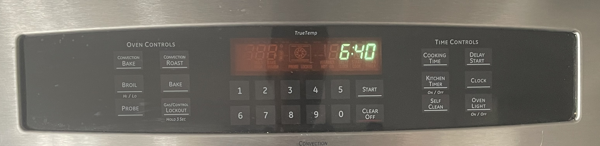

How do I reset the clock on this appliance?
Please provide the instructions in both English and Telugu.
If the instructions involve pressing any buttons, be sure to describe the physical location of those buttons on the appliance.

JSON:


-------Response--------
 **How to reset the clock on a TrueTemp oven**

1. Press and hold the "Clock" button until the display flashes.
2. Use the number buttons to enter the correct time.
3. Press and hold the "Clock" button again to save the new time.

**ఎలా TrueTemp ఓవెన్ మీద గడియారాన్ని రీసెట్ చేయాలి**

1. డిస్‌ప్లే మెరుపు వచ్చే వరకు "క్లాక్" బటన్‌ను నొక్కి పట్టుకోండి.
2. సరైన సమయాన్ని నమోదు చేయడానికి నంబర్ బటన్‌లను ఉపయోగించండి.
3. కొత్త సమయాన్ని సేవ్ చేయడానికి "క్లాక్" బటన్‌ను మళ్లీ నొక్కి పట్టుకోండి.

In [7]:
image_stove_url = "https://storage.googleapis.com/github-repo/img/gemini/multimodality_usecases_overview/stove.jpg"
image_stove = load_image_from_url(image_stove_url)

prompt = """How do I reset the clock on this appliance?
Please provide the instructions in both English and Telugu.
If the instructions involve pressing any buttons, be sure to describe the physical location of those buttons on the appliance.

JSON:
"""

contents = [image_stove, prompt]

responses = multimodal_model.generate_content(contents, stream=True)

print("-------Prompt--------")
print_multimodal_prompt(contents)

print("\n-------Response--------")
for response in responses:
    print(response.text, end="")

Note: The response may not be completely accurate, as the model may hallucinate; however, the model is able to identify the location of buttons and translate in a single query. To mitigate hallucinations, one approach is to ground the LLM with retrieval-augmented generation, which is outside the scope of this notebook.


## Understanding entity relationships in technical diagrams

Gemini has multimodal capabilities that enable it to understand diagrams and take actionable steps, such as optimization or code generation. This example demonstrates how Gemini can decipher an entity relationship (ER) diagram, understand the relationships between tables, identify requirements for optimization in a specific environment like BigQuery, and even generate corresponding code.


-------Prompt--------
Document the entities and relationships in this ER diagram.


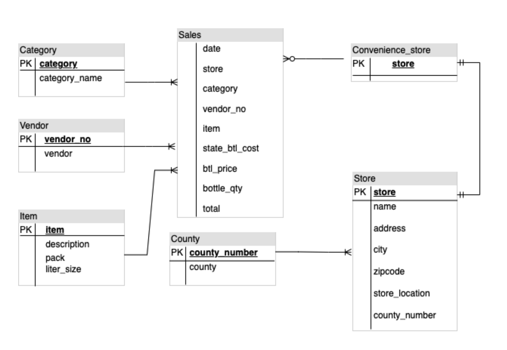


-------Response--------
 The entities in the ER diagram are:

- Category
- Vendor
- Sales
- Convenience_store
- Store
- Item
- County

The relationships in the ER diagram are:

- The Category entity is related to the Sales entity.
- The Vendor entity is related to the Sales entity.
- The Convenience_store entity is related to the Store entity.
- The Store entity is related to the Sales entity.
- The Store entity is related to the County entity.
- The Item entity is related to the Sales entity.

In [8]:
image_er_url = "https://storage.googleapis.com/github-repo/img/gemini/multimodality_usecases_overview/er.png"
image_er = load_image_from_url(image_er_url)

prompt = "Document the entities and relationships in this ER diagram."

contents = [prompt, image_er]

# Use a more deterministic configuration with a low temperature
generation_config = GenerationConfig(
    temperature=0.1,
    top_p=0.8,
    top_k=40,
    candidate_count=1,
    max_output_tokens=2048,
)

responses = multimodal_model.generate_content(
    contents,
    generation_config=generation_config,
    stream=True,
)

print("-------Prompt--------")
print_multimodal_prompt(contents)

print("\n-------Response--------")
for response in responses:
    print(response.text, end="")

## Recommendations based on multiple images

Gemini is capable of image comparison and providing recommendations. This may be useful in industries like e-commerce and retail.

Below is an example of choosing which pair of glasses would be better suited to an oval-shaped face:


-------Prompt--------

Which of these glasses you recommend for me based on the shape of my face?
I have an oval shape face.
----
Glasses 1:



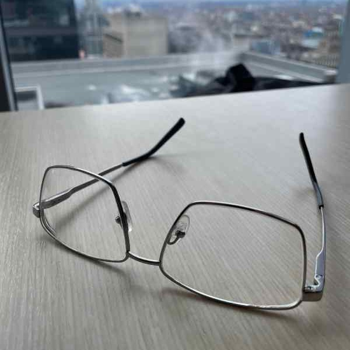


----
Glasses 2:



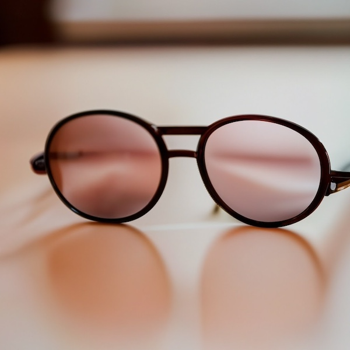


----
Explain how you reach out to this decision.
Provide your recommendation based on my face shape, and reasoning for each in JSON format.


-------Response--------
 ```json
{
  "recommendation": "Glasses 1",
  "reasoning": "Glasses 1 have a rectangular shape, which is a good choice for oval faces. The rectangular shape will help to balance out the length of your face and make it appear more symmetrical. Glasses 2 are a round shape, which is not as flattering for oval faces. The round shape will tend to emphasize the length of your face and make it appear more narrow."
}
```

In [9]:
image_glasses1_url = "https://storage.googleapis.com/github-repo/img/gemini/multimodality_usecases_overview/glasses1.jpg"
image_glasses2_url = "https://storage.googleapis.com/github-repo/img/gemini/multimodality_usecases_overview/glasses2.jpg"
image_glasses1 = load_image_from_url(image_glasses1_url)
image_glasses2 = load_image_from_url(image_glasses2_url)

prompt1 = """
Which of these glasses you recommend for me based on the shape of my face?
I have an oval shape face.
----
Glasses 1:
"""
prompt2 = """
----
Glasses 2:
"""
prompt3 = """
----
Explain how you reach out to this decision.
Provide your recommendation based on my face shape, and reasoning for each in JSON format.
"""

contents = [prompt1, image_glasses1, prompt2, image_glasses2, prompt3]

responses = multimodal_model.generate_content(contents, stream=True)

print("-------Prompt--------")
print_multimodal_prompt(contents)

print("\n-------Response--------")
for response in responses:
    print(response.text, end="")

## Similarity/Differences

Gemini can compare images and identify similarities or differences between objects.

The following example shows two scenes from Marienplatz in Munich, Germany that are slightly different. Gemini can compare between the images and find similarities/differences:


-------Prompt--------

Consider the following two images:
Image 1:



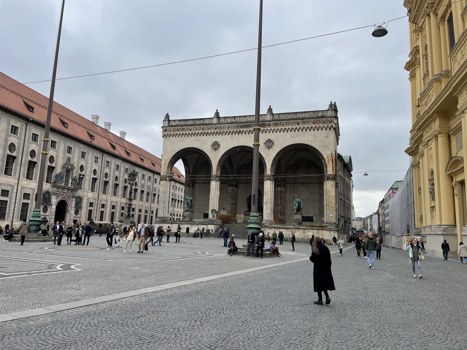


Image 2:



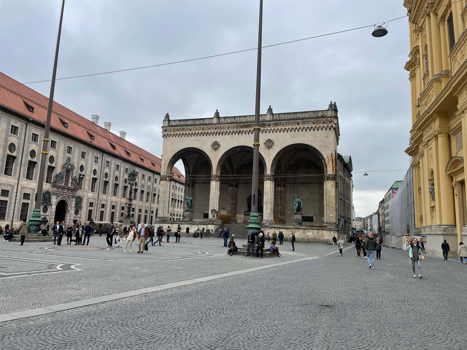


1. What is shown in Image 1?
2. What is creative in the two images?
3. What is difference between Image 1 and Image 2 in terms of the contents or people shown?


-------Response--------
 1. Image 1 shows a square in Munich, Germany. The square is surrounded by buildings, including the Feldherrnhalle, a former military building, and the Residenz, a former royal palace. The square is also home to a number of statues, including a statue of Maximilian I, King of Bavaria.
2. The two images are creative because they show the square from two different perspectives. Image 1 is taken from a ground-level perspective, while Image 2 is taken from a higher angle. This allows viewers to see the square in a different way and to appreciate its beauty from different angles.
3. The difference between Image 1 and Image 2 in terms of the contents or people shown is that Image 1 shows a person in the center of the square, while Image 2 does not. This person is wearing a black jacket and jeans, and they ar

In [10]:
image_landmark1_url = "https://storage.googleapis.com/github-repo/img/gemini/multimodality_usecases_overview/landmark1.jpg"
image_landmark2_url = "https://storage.googleapis.com/github-repo/img/gemini/multimodality_usecases_overview/landmark2.jpg"
image_landmark1 = load_image_from_url(image_landmark1_url)
image_landmark2 = load_image_from_url(image_landmark2_url)

prompt1 = """
Consider the following two images:
Image 1:
"""
prompt2 = """
Image 2:
"""
prompt3 = """
1. What is shown in Image 1?
2. What is creative in the two images?
3. What is difference between Image 1 and Image 2 in terms of the contents or people shown?
"""

contents = [prompt1, image_landmark1, prompt2, image_landmark2, prompt3]

generation_config = GenerationConfig(
    temperature=0.0,
    top_p=0.8,
    top_k=20,
    candidate_count=1,
    max_output_tokens=2048,
)

responses = multimodal_model.generate_content(
    contents,
    generation_config=generation_config,
    stream=True,
)

print("-------Prompt--------")
print_multimodal_prompt(contents)

print("\n-------Response--------")
for response in responses:
    print(response.text, end="")

## Generating a video description

Gemini can also extract tags throughout a video:

> Video: https://storage.googleapis.com/github-repo/img/gemini/multimodality_usecases_overview/mediterraneansea.mp4

In [11]:
prompt = """
What is shown in this video?
Where should I go to see it?
What are the top 5 places in the world that look like this?
"""
video = Part.from_uri(
    uri="gs://github-repo/img/gemini/multimodality_usecases_overview/mediterraneansea.mp4",
    mime_type="video/mp4",
)
contents = [prompt, video]

responses = multimodal_model.generate_content(contents, stream=True)

print("-------Prompt--------")
print_multimodal_prompt(contents)

print("\n-------Response--------")
for response in responses:
    print(response.text, end="")

-------Prompt--------

What is shown in this video?
Where should I go to see it?
What are the top 5 places in the world that look like this?




-------Response--------
 This is a video of the Mediterranean Sea in Turkey. 

You can visit the Mediterranean Sea in Turkey by flying into Antalya Airport (AYT) or Dalaman Airport (DLM). 

The top 5 places in the world that look like this are:

1. The Amalfi Coast, Italy
2. The Cinque Terre, Italy
3. Santorini, Greece
4. Positano, Italy
5. Dubrovnik, Croatia

> You can confirm that the location is indeed Antalya, Turkey by visiting the Wikipedia page: https://en.wikipedia.org/wiki/Antalya


## Extracting tags of objects throughout the video

Gemini can also extract tags throughout a video.

> Video: https://storage.googleapis.com/github-repo/img/gemini/multimodality_usecases_overview/photography.mp4


In [12]:
prompt = """
Answer the following questions using the video only:
- What is in the video?
- What is the action in the video?
- Provide 10 best tags for this video?
"""
video = Part.from_uri(
    uri="gs://github-repo/img/gemini/multimodality_usecases_overview/photography.mp4",
    mime_type="video/mp4",
)
contents = [prompt, video]

responses = multimodal_model.generate_content(contents, stream=True)

print("-------Prompt--------")
print_multimodal_prompt(contents)

print("\n-------Response--------")
for response in responses:
    print(response.text, end="")

-------Prompt--------

Answer the following questions using the video only:
- What is in the video?
- What is the action in the video?
- Provide 10 best tags for this video?




-------Response--------
 * A man is taking pictures of a table with a camera.
* The table is made of wood and has a lot of decorations on it.
* There are two chairs in the background of the photo.
* There is a plant in the background of the photo.
* The man is wearing a hat.
* The man is wearing a black shirt.
* The man is wearing khaki shorts.
* The man is wearing sneakers.
* The man has a camera strap around his neck.
* The man has a camera in his hand.

* home decor
* interior design
* photography
* lifestyle
* travel
* vacation
* Mexico
* Tulum
* Casa Malca
* Pablo Escobar

## Asking more questions about a video

Below is another example of using Gemini to ask questions the video and return a JSON response.

> Video: https://storage.googleapis.com/github-repo/img/gemini/multimodality_usecases_overview/pixel8.mp4  
> _Note: Although this video contains audio, Gemini does not currently support audio input and will only answer based on the video._

In [13]:
prompt = """
Answer the following questions using the video only:
What is the profession of the main person?
What are the main features of the phone highlighted?
Which city was this recorded in?
Provide the answer JSON.
"""
video = Part.from_uri(
    uri="gs://github-repo/img/gemini/multimodality_usecases_overview/pixel8.mp4",
    mime_type="video/mp4",
)
contents = [prompt, video]

responses = multimodal_model.generate_content(contents, stream=True)

print("-------Prompt--------")
print_multimodal_prompt(contents)

print("\n-------Response--------")
for response in responses:
    print(response.text, end="")

-------Prompt--------

Answer the following questions using the video only:
What is the profession of the main person?
What are the main features of the phone highlighted?
Which city was this recorded in?
Provide the answer JSON.




-------Response--------
 ```json
{
  "person": {
    "name": "Saeka Shimada",
    "profession": "photographer"
  },
  "phone": {
    "brand": "Google",
    "model": "Pixel 8",
    "features": ["Video Boost", "Night Sight"]
  },
  "city": "Tokyo",
  "country": "Japan"
}
```

## Retrieving extra information beyond the video


> Video: https://storage.googleapis.com/github-repo/img/gemini/multimodality_usecases_overview/ottawatrain3.mp4


In [14]:
prompt = """
Which line is this?
where does it go?
What are the stations/stops?
"""
video = Part.from_uri(
    uri="gs://github-repo/img/gemini/multimodality_usecases_overview/ottawatrain3.mp4",
    mime_type="video/mp4",
)
contents = [prompt, video]

responses = multimodal_model.generate_content(contents, stream=True)

print("-------Prompt--------")
print_multimodal_prompt(contents)

print("\n-------Response--------")
for response in responses:
    print(response.text, end="")

-------Prompt--------

Which line is this?
where does it go?
What are the stations/stops?




-------Response--------
 The Confederation Line is a light rail line in Ottawa, Ontario, Canada. It is operated by OC Transpo and connects Tunney's Pasture to Blair. The line has 13 stations and is 12.5 kilometres (7.8 mi) long.

The Confederation Line was opened on September 14, 2019. It is the first light rail line in Ottawa since the O-Train was closed in 2001. The line has been a success, with ridership exceeding expectations.

The Confederation Line has had a positive impact on the city of Ottawa. It has improved transportation options for residents and has helped to reduce traffic congestion. The line has also been a catalyst for development in the city's downtown core.

The Confederation Line is a key part of Ottawa's transportation network. It is a reliable and efficient way to get around the city. The line is also a popular tourist attraction, with many visitors to Ottawa taking a ride on the train.

> You can confirm that this is indeed the Confederation Line on Wikipedia here: https://en.wikipedia.org/wiki/Confederation_Line
